In [220]:
from utils.EDA.analysis import *
from utils.EDA.visualize import *

In [221]:
def LinearReg(data, target, *features):
    y = np.array(data[target])[np.newaxis].T

    X = np.ones([len(data), 1])
    for feature in features:
        X = np.hstack((X, np.array(data[feature])[np.newaxis].T))

    w, resid, rank, s = np.linalg.lstsq(X, y)

    print("w{} : {}".format("Const", w[0]), end = " ")
    
    for i in range(len(w)-1):
        print("w{} : {}".format(features[i], w[i+1]), end = " ")
        
    RMSE = np.sqrt(resid / len(data))
    print("\n RMSE : {}".format(RMSE))
    print("rank : {}".format(rank))
    
    print("cross validation : {}".format(crossValidation(10, data, target, *features)))
    
    # draw chart
    # 예측치와 실제치과의 관계표시(scatter plot)
    predict = np.dot(X, w)
    
    plt.scatter(y, predict)
    plt.xlabel("target value")
    plt.ylabel("predict value")
    plt.xlim(data[target].min(), data[target].max())
    plt.show()

In [222]:
plt.style.use("ggplot")

In [223]:
df_train = pd.read_csv("../data/new_train.csv")
df_test = pd.read_csv("../data/test.csv")

# LinearRegression

wConst : [ 10.56172392] wOverallQual : [ 0.13908248] w1stFlrSF : [  3.84602384e-05] wGrLivArea : [ 0.00019306] wGarageArea : [ 0.00034789] wTotalBsmtSF : [ 0.00010608] 
 RMSE : [ 0.18461018]
rank : 6
cross validation : 0.18583463257949132


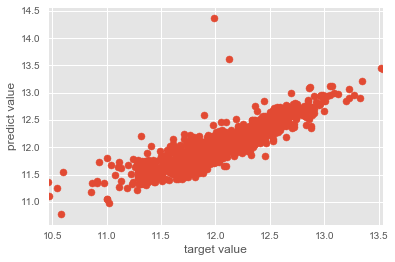

In [230]:
LinearReg(df_train, "log_SalePrice", "OverallQual", "1stFlrSF", "GrLivArea", "GarageArea", "TotalBsmtSF")

523, 1298

# cross validation

In [151]:
def crossValidation(num, data, target, *features):
    rmses = []
    
    # 데이터프래임에서 target과 features 추출 
    data = data[[*features, target]]
    
    # 데이터프래임 num 갯수로 분할
    remain = data.shape[0] % num
    data_set = np.split(data.values[:data.shape[0]-remain], num)
    data_set[num-1] = np.vstack([data_set[num-1], data.values[data.shape[0]-remain:]])
    
    # 각 fold로 계산하여 rmse를 계산
    for i in range(num):
        
        # test_set과 train_set 제작
        test_set = data_set[i] # test set 

        if (i==0): # train set
            train_set = data_set[1:]
        elif (i==9):
            train_set = data_set[:num-1]
        else:
            train_set = data_set[:i]
            train_set += data_set[i+1:]
        train_set = np.concatenate(train_set)
        
        # train_set으로 linear regression 모델 훈련
        y = train_set[:, -1][np.newaxis].T
        X = np.ones([train_set.shape[0], 1])
        X = np.hstack((X, train_set[:, :train_set.shape[1]-1]))
        
        w, resid, rank, s = np.linalg.lstsq(X, y)
        
        # test_set으로 predict 계산 및 target 생성
        test_X = np.hstack((np.ones([test_set.shape[0], 1]), test_set[:, :test_set.shape[1]-1]))
        predict_test = np.dot(test_X, w).T[0]
        target_test = test_set[:,-1]
        
        # rmse 계산
        rss = np.square(predict_test - target_test).sum()
        rmses.append(np.sqrt(rss / test_X.shape[0]))    
    
    # rmse_avr 계산
    rmse_avr = sum(rmses) / num
    
    # print rmse
#     for idx, rmse in enumerate(rmses):
#         print("test{} : {:1.2f}".format(idx, rmse), end = " ")
    
#     print("\n average of rmse : {:1.2f}".format(rmse_avr))
    return rmse_avr
        

In [152]:
crossValidation(11, df_train, "SalePrice", "Id", "OverallQual", "1stFlrSF")

43675.037589598673

### 실험

In [153]:
import statsmodels.api as sm

In [154]:
def LinearRegSM(data, target, *features):
    y = np.array(data[target])[np.newaxis].T
    
    #data[*features]
    dfX = sm.add_constant(data[[*features]])
    dfy = data[target]
    
    model = sm.OLS(dfy, dfX)
    result = model.fit()
    print(result.summary())
    return result

In [155]:
LinearRegSM(df_train, "SalePrice", "LotFrontage")

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     130.6
Date:                Mon, 26 Feb 2018   Prob (F-statistic):           5.11e-29
Time:                        16:31:45   Log-Likelihood:                -18481.
No. Observations:                1460   AIC:                         3.697e+04
Df Residuals:                    1458   BIC:                         3.698e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.251e+05   5275.466     23.715      

wConst : [ 2.6543195] wOverallQual : [ 0.09522021] wGrLivArea : [ 0.00021726] wGarageCars : [ 0.0717898] wGarageArea : [  5.29640591e-05] wTotalBsmtSF : [  8.98129791e-05] w1stFlrSF : [  5.73890350e-05] wFullBath : [-0.01976209] wTotRmsAbvGrd : [ 0.00685455] wYearBuilt : [ 0.00189194] wYearRemodAdd : [ 0.0022182] 
 RMSE : [ 0.16914043]
rank : 11
cross validation : 0.17158028913341314


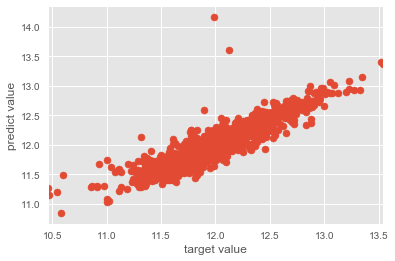

In [233]:
LinearReg(df_train, "log_SalePrice", "OverallQual", "GrLivArea",  "GarageCars", "GarageArea", "TotalBsmtSF", "1stFlrSF", "FullBath", "TotRmsAbvGrd", "YearBuilt", "YearRemodAdd")

In [76]:
LinearRegSM(df_train, "SalePrice", "OverallQual", "GrLivArea",  "GarageCars", "GarageArea", "TotalBsmtSF", "1stFlrSF", "FullBath", "TotRmsAbvGrd", "YearBuilt", "YearRemodAdd")

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     495.4
Date:                Mon, 26 Feb 2018   Prob (F-statistic):               0.00
Time:                        14:46:57   Log-Likelihood:                -17459.
No. Observations:                1460   AIC:                         3.494e+04
Df Residuals:                    1449   BIC:                         3.500e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.186e+06   1.29e+05     -9.187   

In [157]:
top10 = ["OverallQual", "GrLivArea",  "GarageCars", "GarageArea", "TotalBsmtSF", "1stFlrSF", "FullBath", "TotRmsAbvGrd", "YearBuilt", "YearRemodAdd"]

In [158]:
data_cor = df_train[top10].corr()
get_top_abs_cor(df_train[top10], 10)

GarageCars   GarageArea      0.882475
GrLivArea    TotRmsAbvGrd    0.825489
TotalBsmtSF  1stFlrSF        0.819530
GrLivArea    FullBath        0.630012
OverallQual  GarageCars      0.600671
             GrLivArea       0.593007
YearBuilt    YearRemodAdd    0.592855
OverallQual  YearBuilt       0.572323
GrLivArea    1stFlrSF        0.566024
OverallQual  GarageArea      0.562022
dtype: float64

연관이 있는 값인 (GarageCars, GarageArea), (GrLivArea, TotRmsAbvGrd), (TotalBsmtSF, 1stFlrSF) 에서 "GarageArea", "TotRmsAbvGrd", "1stFlrSF" 제거
37686 -> 37591 로 감소

In [159]:
result = LinearRegSM(df_train, "SalePrice", "OverallQual", "GrLivArea",  "GarageArea", "TotalBsmtSF", "FullBath", "YearBuilt", "YearRemodAdd")

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     696.5
Date:                Mon, 26 Feb 2018   Prob (F-statistic):               0.00
Time:                        16:31:50   Log-Likelihood:                -17470.
No. Observations:                1460   AIC:                         3.496e+04
Df Residuals:                    1452   BIC:                         3.500e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.214e+06   1.28e+05     -9.498   

# Logarithm

SalePrice

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 10.46024211,  10.47194981,  10.54270639, ...,  13.34550693,
          13.5211395 ,  13.53447303])),
 (0.39826223081618872, 12.024050901109383, 0.99537614756366133))

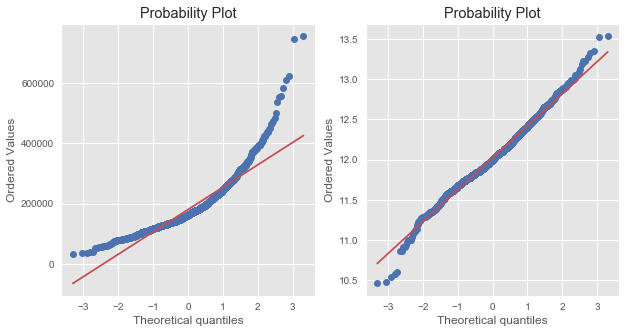

In [219]:
log_SalePrice = np.log(df_train["SalePrice"])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sp.stats.probplot(df_train["SalePrice"], plot = axes[0])
sp.stats.probplot(log_SalePrice, plot = axes[1])

LotFrontage(선택)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 3.04452244,  3.04452244,  3.04452244, ...,  5.82699111,
          5.98832974,  6.00581901])),
 (0.37349497217086036, 4.2683518701134853, 0.97777186333051269))

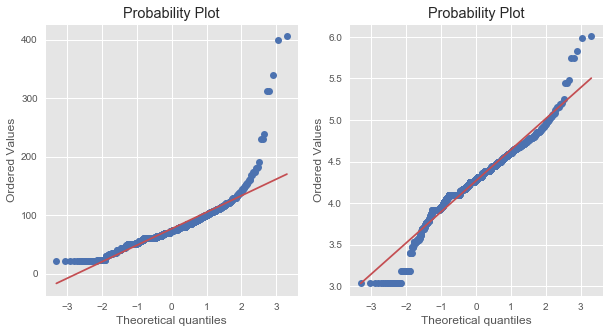

In [160]:
log_Frontage = np.log(df_train["LotFrontage"])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sp.stats.probplot(df_train["LotFrontage"], plot = axes[0])
sp.stats.probplot(log_Frontage, plot = axes[1])

LotArea(선택)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([  7.17011954,   7.29776828,   7.30720231, ...,  11.97665948,
          12.01163802,  12.27953219])),
 (0.49279975916869634, 9.1108382395055472, 0.95079366848515501))

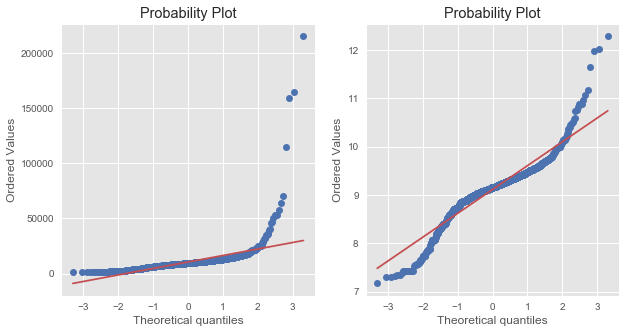

In [161]:
log_LotArea = np.log(df_train["LotArea"])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sp.stats.probplot(df_train["LotArea"], plot = axes[0])
sp.stats.probplot(log_LotArea, plot = axes[1])

1stFlrSF(선택)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 5.81114099,  5.91889385,  6.08221891, ...,  8.05134093,
          8.07961803,  8.45361421])),
 (0.31748920647999668, 7.0075014449454125, 0.99759244073844833))

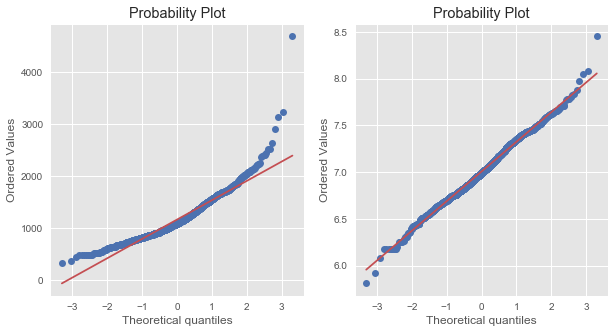

In [177]:
log_1stFlrSF = np.log(df_train["1stFlrSF"])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sp.stats.probplot(df_train["1stFlrSF"], plot = axes[0])
sp.stats.probplot(log_1stFlrSF, plot = axes[1])

GrLivArea(선택)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 5.81114099,  6.08221891,  6.1737861 , ...,  8.40648507,
          8.45019832,  8.63799389])),
 (0.33334425318908878, 7.2677743833110044, 0.9977323160680609))

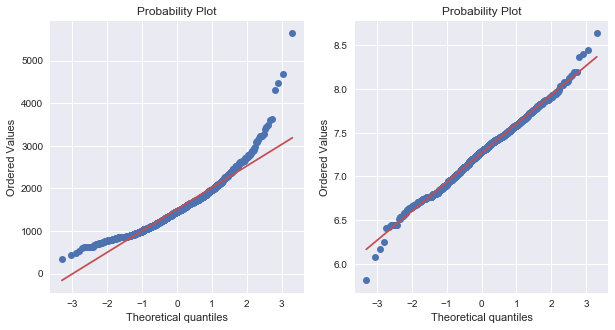

In [115]:
log_GrLivArea = np.log(df_train["GrLivArea"])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sp.stats.probplot(df_train["GrLivArea"], plot = axes[0])
sp.stats.probplot(log_GrLivArea, plot = axes[1])

wConst : [-0.38329383] wOverallQual : [ 0.09014485] wlog_GrLivArea : [ 0.44144797] wGarageArea : [ 0.00024651] wTotalBsmtSF : [ 0.00012586] wFullBath : [-0.02808901] wYearBuilt : [ 0.00202793] wYearRemodAdd : [ 0.00223988] 
 RMSE : [ 0.16603829]
rank : 8
cross validation : 0.1664739612579515


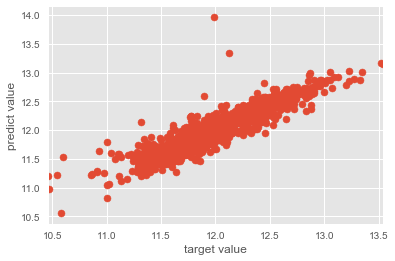

In [243]:
#log 사용(SalePrice, GrLivArea)
result = LinearReg(df_train, "log_SalePrice", "OverallQual", "log_GrLivArea",  "GarageArea", "TotalBsmtSF", "FullBath", "YearBuilt", "YearRemodAdd")
# 0.17 -> 0.16